In [1]:
from sklearn.mixture import GaussianMixture
import numpy as np
import copy
import os
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append('../induction_motor_anomaly_detection/')
import modules,scaler

In [2]:
normal_data = pd.read_csv('../data/combined_data.csv')
anomalous_data = pd.read_csv('../anomalous_data/combined_anomalous.csv')

In [4]:
train_scaler = scaler.Scaler()
train_scaler.fit_unlabelled_data(normal_data)

using MinMaxScaler()


In [5]:
train_scaled = train_scaler.transform(normal_data)
anomalous_scaled = train_scaler.transform(anomalous_data)

In [3]:
gmm = GaussianMixture(n_components=1, covariance_type='full')


In [6]:
gmm.fit(train_scaled[0:10000])

GaussianMixture()

In [7]:
scores = gmm.score_samples(train_scaled[0:10000])
mean_score = np.mean(scores)
std_score = np.std(scores)
threshold = mean_score - 3 * std_score
is_anomaly = gmm.score_samples(train_scaled[0:10000]) < threshold

In [9]:
np.where(is_anomaly == True)

(array([  20,   32,  183,  222,  340,  379,  457,  575,  614,  692,  810,
        1046, 1085, 1124, 1203, 1243, 1321, 1360, 1439, 1517, 1556, 1595,
        1713, 1752, 1791, 1909, 2027, 2223, 2263, 2302, 2341, 2380, 2420,
        2499, 2695, 2734, 2773, 2812, 2890, 3008, 3087, 3322, 3400, 3439,
        3478, 3556, 3595, 3791, 3870, 3909, 4066, 4302, 4341, 4576, 4694,
        4733, 4772, 5008, 5047, 5087, 5126, 5362, 5401, 5558, 5597, 5715,
        5794, 5872, 5951, 5990, 6068, 6107, 6186, 6264, 6303, 6382, 6460,
        6538, 6656, 6695, 6774, 6852, 6930, 6969, 7126, 7165, 7283, 7322,
        7518, 7596, 7906, 7984, 8063, 8102, 8180, 8258, 8297, 8454, 8532,
        8611, 8804, 8922, 9129, 9168, 9207, 9347, 9426, 9504, 9582, 9660,
        9700, 9739, 9818, 9896, 9935, 9974], dtype=int64),)

In [21]:
class AnomalyDetector:
    def __init__(self, n_components=1, covariance_type='full', k_threshold_std_dev=3, concat = True):
        self.n_components = n_components
        self.covariance_type = covariance_type
        self.k_threshold_std_dev = k_threshold_std_dev
        self.gmm = None
        self.X = np.array([])
        self.concat = concat

    def fit(self, X):
        """
        Fit the Gaussian Mixture Model to the training data.
        """
        
        if self.gmm is None:
            self.gmm = GaussianMixture(n_components=self.n_components, covariance_type=self.covariance_type)
            self.gmm.fit(X)
            self.X = X
        else:
            self.X = np.concatenate((self.X, X), axis=0)
            if self.concat :
                self.gmm.fit(self.X)
            else:
                self.gmm.fit(X)
            
        # This tells the GMM to initialize the model parameters using the k-means algorithm, which can be more efficient than the default random initialization for large datasets

    def predict(self, X_test):
        """
        Predict whether the data is anomalous or not based on the GMM.
        """
        scores = self.gmm.score_samples(self.X)
        k = self.k_threshold_std_dev
        mean_score = np.mean(scores)
        std_score = np.std(scores)
        threshold = mean_score - k * std_score
        is_anomaly = self.gmm.score_samples(X_test) < threshold
        return is_anomaly


In [24]:
anomaly_detector = AnomalyDetector(n_components=1, covariance_type='full', k_threshold_std_dev=3,concat=False)


In [25]:
anomaly_detector.fit(train_scaled[0:10000])

In [26]:
anomaly_predictions = anomaly_detector.predict(train_scaled[0:10000])


2


In [ ]:
from tqdm import tqdm

for i in tqdm(range(0,len(train_scaled),10000)):
    anomaly_detector.fit(train_scaled[i:i+10000])

TypeError: Input z must be 2D, not 3D

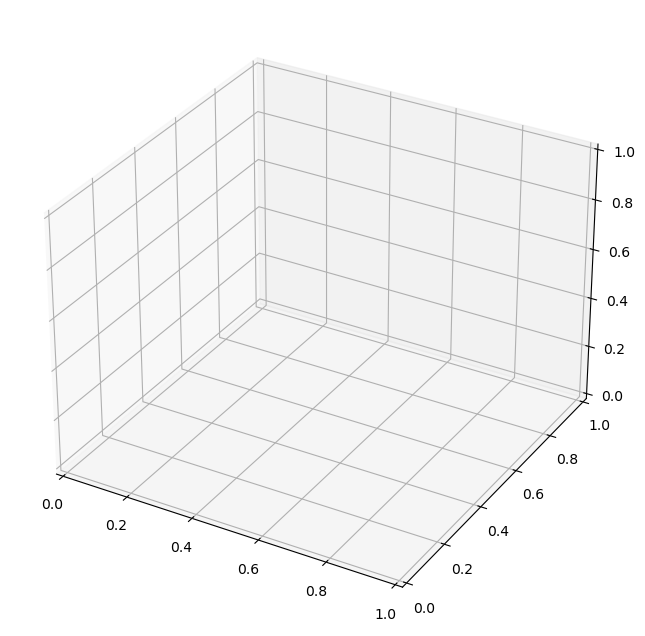

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import OneClassSVM
from mpl_toolkits.mplot3d import Axes3D

# Create and fit one-class SVM model
X = np.random.randn(100, 3)
clf = OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
clf.fit(X)

# Compute decision function on a grid
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
z_min, z_max = X[:, 2].min() - 1, X[:, 2].max() + 1
xx, yy, zz = np.meshgrid(np.linspace(x_min, x_max, 50),
                         np.linspace(y_min, y_max, 50),
                         np.linspace(z_min, z_max, 50))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel(), zz.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision function and support vectors
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.contour3D(xx, yy, zz, Z, cmap=plt.cm.Blues_r)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], color='black')
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], clf.support_vectors_[:, 2],
           s=100, linewidth=1, facecolors='none', edgecolors='black')
plt.show()
